# Imports

In [20]:
import pandas as pd
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

# Data preparation

In [21]:
df = pd.read_excel("AB_Test_Results.xlsx")

In [22]:
df.USER_ID.nunique()

6324

Количество уникальных пользователей, учавствовавших в A/B тесте - 6324.

In [23]:
new_df = df.groupby(["USER_ID", "VARIANT_NAME"], as_index=False).agg({"REVENUE": "sum"})

In [24]:
uc = new_df[new_df.VARIANT_NAME == "control"]
uv = new_df[new_df.VARIANT_NAME == "variant"]

In [25]:
check_users = uc.merge(uv, on='USER_ID', how="inner")

In [26]:
check_users.shape

(1541, 5)

1541 пользователь был как в контрольной так и в тестовой группе. Следует исключить их из итоговой выборки так как оценка влияния теста с ними будет несостоятельной.

In [27]:
new_df = new_df[~new_df.USER_ID.isin(check_users.USER_ID)]

Диаграмма "Ящик с усами"

<AxesSubplot:xlabel='VARIANT_NAME', ylabel='REVENUE'>

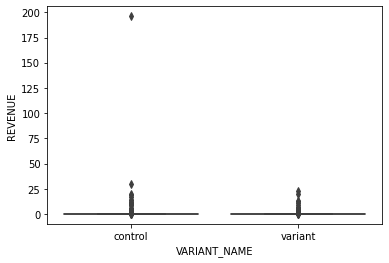

In [28]:
sns.boxplot(x="VARIANT_NAME", y="REVENUE", data=new_df)

Как видно из графика выше, в контрольной группе имеется значительный выброс. Уберем его.

In [29]:
new_df = new_df[new_df.REVENUE != new_df.REVENUE.max()]

<AxesSubplot:xlabel='VARIANT_NAME', ylabel='REVENUE'>

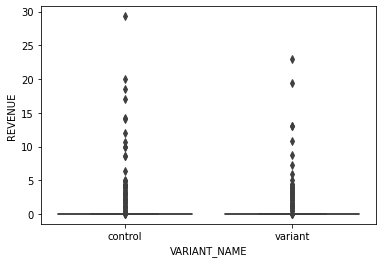

In [30]:
sns.boxplot(x="VARIANT_NAME", y="REVENUE", data=new_df)

Таблица сводной статистики по группам

In [31]:
ab_df = new_df.groupby("VARIANT_NAME", as_index=False).agg({"REVENUE": ["sum", "mean","std","min","max"]})

In [32]:
ab_df

VARIANT_NAME REVENUE                                
                   sum      mean       std  min    max
0      control  274.55  0.114923  1.162495  0.0  29.32
1      variant  179.32  0.074935  0.858207  0.0  23.04

In [33]:
rev_c = new_df[new_df.VARIANT_NAME == "control"]["REVENUE"]
rev_v = new_df[new_df.VARIANT_NAME == "variant"]["REVENUE"]

# Results

Проверка распределения ВЫРУЧКИ на нормальность

* H_0: Данные выборки существенно не отличаются от данных для нормального распределения.
* H_1: данные выборки значительно отличаются от данных для для нормального распределения.

In [34]:
shapiro(rev_c)

ShapiroResult(statistic=0.0746118351817131, pvalue=0.0)

In [35]:
shapiro(rev_v)

ShapiroResult(statistic=0.061459869146347046, pvalue=0.0)

Результат теста Шапиро Уилка p < 0,05 для Группы A и Группы B, что указывает на то, что гипотеза H_0 отклонена.

U-тест Манна-Уитни для ВЫРУЧКУ

* H_0: Распределение значений двух групп равны
* H_1: Распределение значений двух групп не равно

In [36]:
mannwhitneyu(rev_c, rev_v)

MannwhitneyuResult(statistic=2845109.0, pvalue=0.12399777553410979)

Результат U-теста Манна-Уитни p > 0,05, что указывает на то, что H_0 не может быть отклонена. Соответственно, нет существенной разницы между Группой А и Группой В в распределении ВЫРУЧКИ.

На основе проведенных выше изысканий, рекомендую оставить контрольную версию, т.к. статистически значимых различий нет, но по средним и суммарным показателям контрольная группа лучше тестовой.